In [1]:
x=1

In [47]:
import multimil as mtm
import scanpy as sc
import scvi
import pandas as pd
import sklearn
import numpy as np
import torch
import anndata as ad

In [3]:
torch.set_float32_matmul_precision('medium')

In [4]:
sc.set_figure_params(vector_friendly=True)

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Global seed set to 0


Last run with scvi-tools version: 0.20.3


In [7]:
adata1 = sc.read('../../recomb_multimodal_q2r/pipeline/data/cite_rna.h5ad')
adata2 = sc.read('../../recomb_multimodal_q2r/pipeline/data/cite_adt.h5ad')

In [8]:
adata1

AnnData object with n_obs × n_vars = 90261 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    uns: 'dataset_id', 'genome', 'hvg', 'log1p', 'organism'

In [9]:
adata2

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    uns: 'dataset_id', 'genome', 'organism'

In [10]:
split_key = 'split'

In [11]:
# split into train and test
test_idx = adata2.obs[split_key] == 'test'

adata2_test = adata2[test_idx].copy()
adata2_train = adata2[~test_idx].copy()

adata1_test = adata1[test_idx].copy()
adata1_train = adata1[~test_idx].copy()

In [12]:
adata = mtm.data.organize_multimodal_anndatas(
        adatas=[[adata1_train, adata1_test], [adata2_train, None]],
        )

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [13]:
mtm.model.MultiVAE.setup_anndata(
        adata, 
        rna_indices_end=adata1_train.n_vars,
        categorical_covariate_keys=['Site'],
    )

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [14]:
losses = ['nb', 'mse']

In [15]:
loss_params = {'kl': 0.00001, 'integ': 10}

In [16]:
model_params = {
        "z_dim": 16,
        "cond_dim": 16,
        "mix": 'product',
        "integrate_on": 'Site',
        "modality_alignment": 'MMD',
        "alignment_type": 'marginal',
}

In [17]:
vae = mtm.model.MultiVAE(
        adata,
        losses=losses,
        loss_coefs=loss_params,
        **model_params,
    )

In [18]:
vae.train(
    lr=0.0001,
    batch_size=256, 
    max_epochs=200,
)

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lustre/groups/ml01/workspace/anastasia.litinetskaya ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /lustre/groups/ml01/workspace/anastasia.litinetskaya ..

Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/lib/python3.10/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)


Epoch 200/200: 100%|██████████| 200/200 [38:35<00:00, 11.08s/it, loss=651, v_num=1]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [38:36<00:00, 11.58s/it, loss=651, v_num=1]


In [19]:
vae.get_model_output(batch_size=256)


In [20]:
vae.impute()

In [21]:
adata.write('data/cite_imputed.h5ad')

In [22]:
vae.save('data/model/', overwrite=True)

In [23]:
adata

AnnData object with n_obs × n_vars = 90261 × 2134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: 'modality_lengths', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: '_scvi_extra_categorical_covs', 'X_multiMIL', 'imputed_modality_0', 'imputed_modality_1'

## viz imputation

In [17]:
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad

sc.set_figure_params(vector_friendly=True, figsize=(4,4))

In [2]:
adata = sc.read('data/cite_imputed.h5ad')
adata

AnnData object with n_obs × n_vars = 90261 × 2134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'modality_lengths'
    obsm: 'X_multiMIL', '_scvi_extra_categorical_covs', 'imputed_modality_0', 'imputed_modality_1'

In [7]:
adata2 = sc.read('../../recomb_multimodal_q2r/pipeline/data/cite_adt.h5ad')
adata2

AnnData object with n_obs × n_vars = 90261 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split'
    uns: 'dataset_id', 'genome', 'organism'

In [3]:
adata_test = adata[adata.obs['split'] == 'test'].copy()
adata_test

AnnData object with n_obs × n_vars = 16311 × 2134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'modality_lengths'
    obsm: 'X_multiMIL', '_scvi_extra_categorical_covs', 'imputed_modality_0', 'imputed_modality_1'

In [4]:
adata_imputed_adt = sc.AnnData(adata_test.obsm['imputed_modality_1'], obs=adata_test.obs)
adata_imputed_adt

AnnData object with n_obs × n_vars = 16311 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split', 'group', 'size_factors', '_scvi_batch'

In [5]:
sc.pp.neighbors(adata_imputed_adt)
sc.tl.umap(adata_imputed_adt)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [8]:
adata_imputed_adt.var_names = adata2.var_names

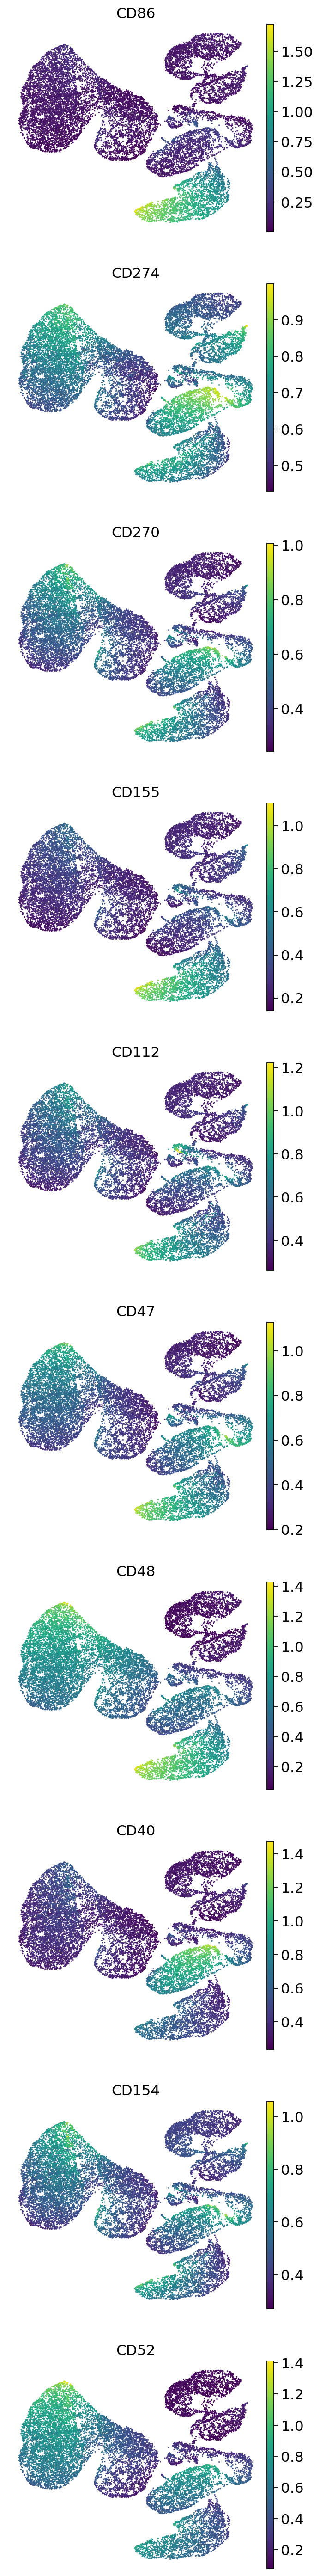

In [9]:
# double check that there is variability in the imputed data
sc.pl.umap(adata_imputed_adt, color=list(adata_imputed_adt.var_names)[:10], ncols=1, frameon=False)

In [10]:
adata_test_rna = adata_test[:, :2000].copy()
adata_test_rna

AnnData object with n_obs × n_vars = 16311 × 2000
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split', 'group', 'size_factors', '_scvi_batch'
    var: 'modality'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'modality_lengths'
    obsm: 'X_multiMIL', '_scvi_extra_categorical_covs', 'imputed_modality_0', 'imputed_modality_1'

In [11]:
sc.pp.neighbors(adata_test_rna)
sc.tl.umap(adata_test_rna)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


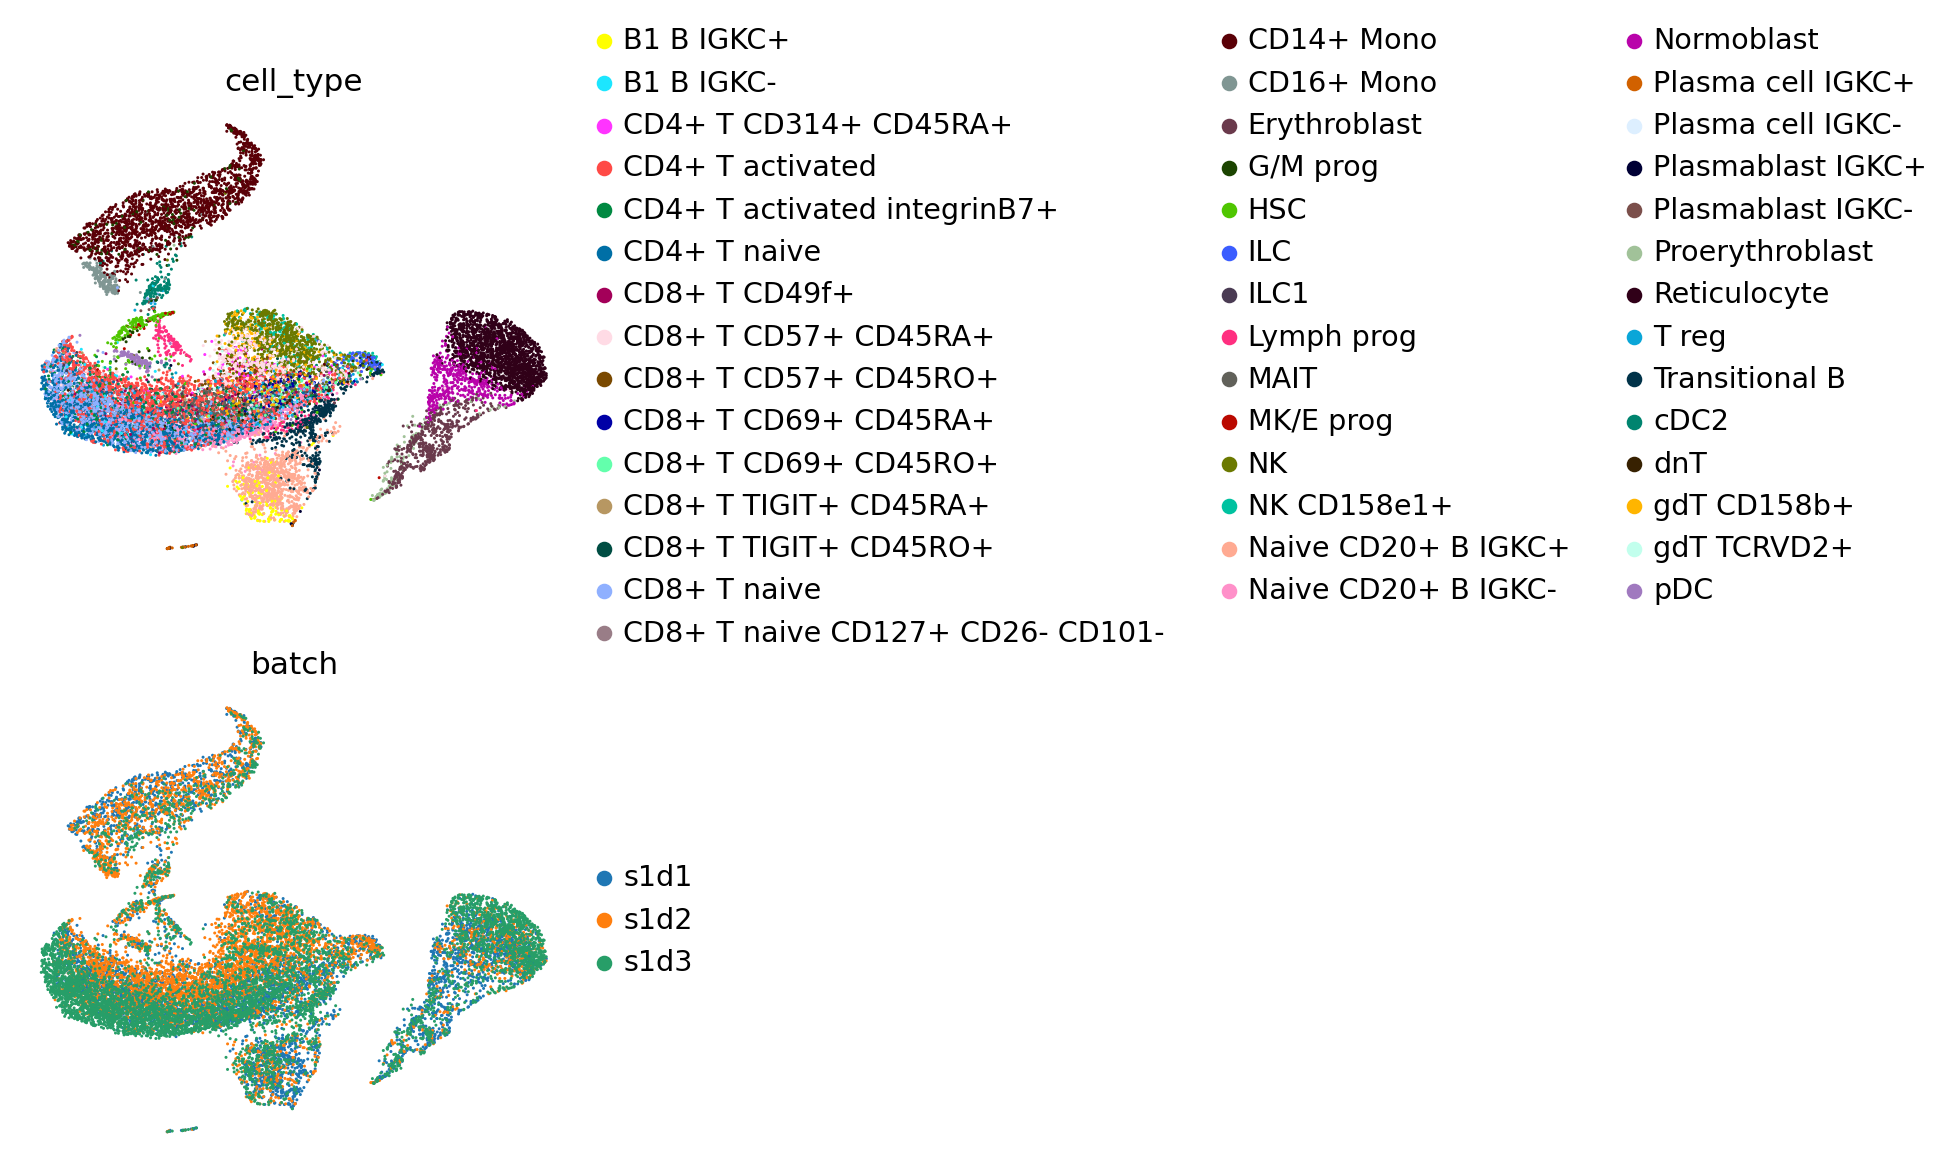

In [21]:
sc.pl.umap(adata_test_rna, color=['cell_type', 'batch'], ncols=1, frameon=False, save='_rna.svg')

In [13]:
adata_imputed_adt

AnnData object with n_obs × n_vars = 16311 × 134
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split', 'group', 'size_factors', '_scvi_batch'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


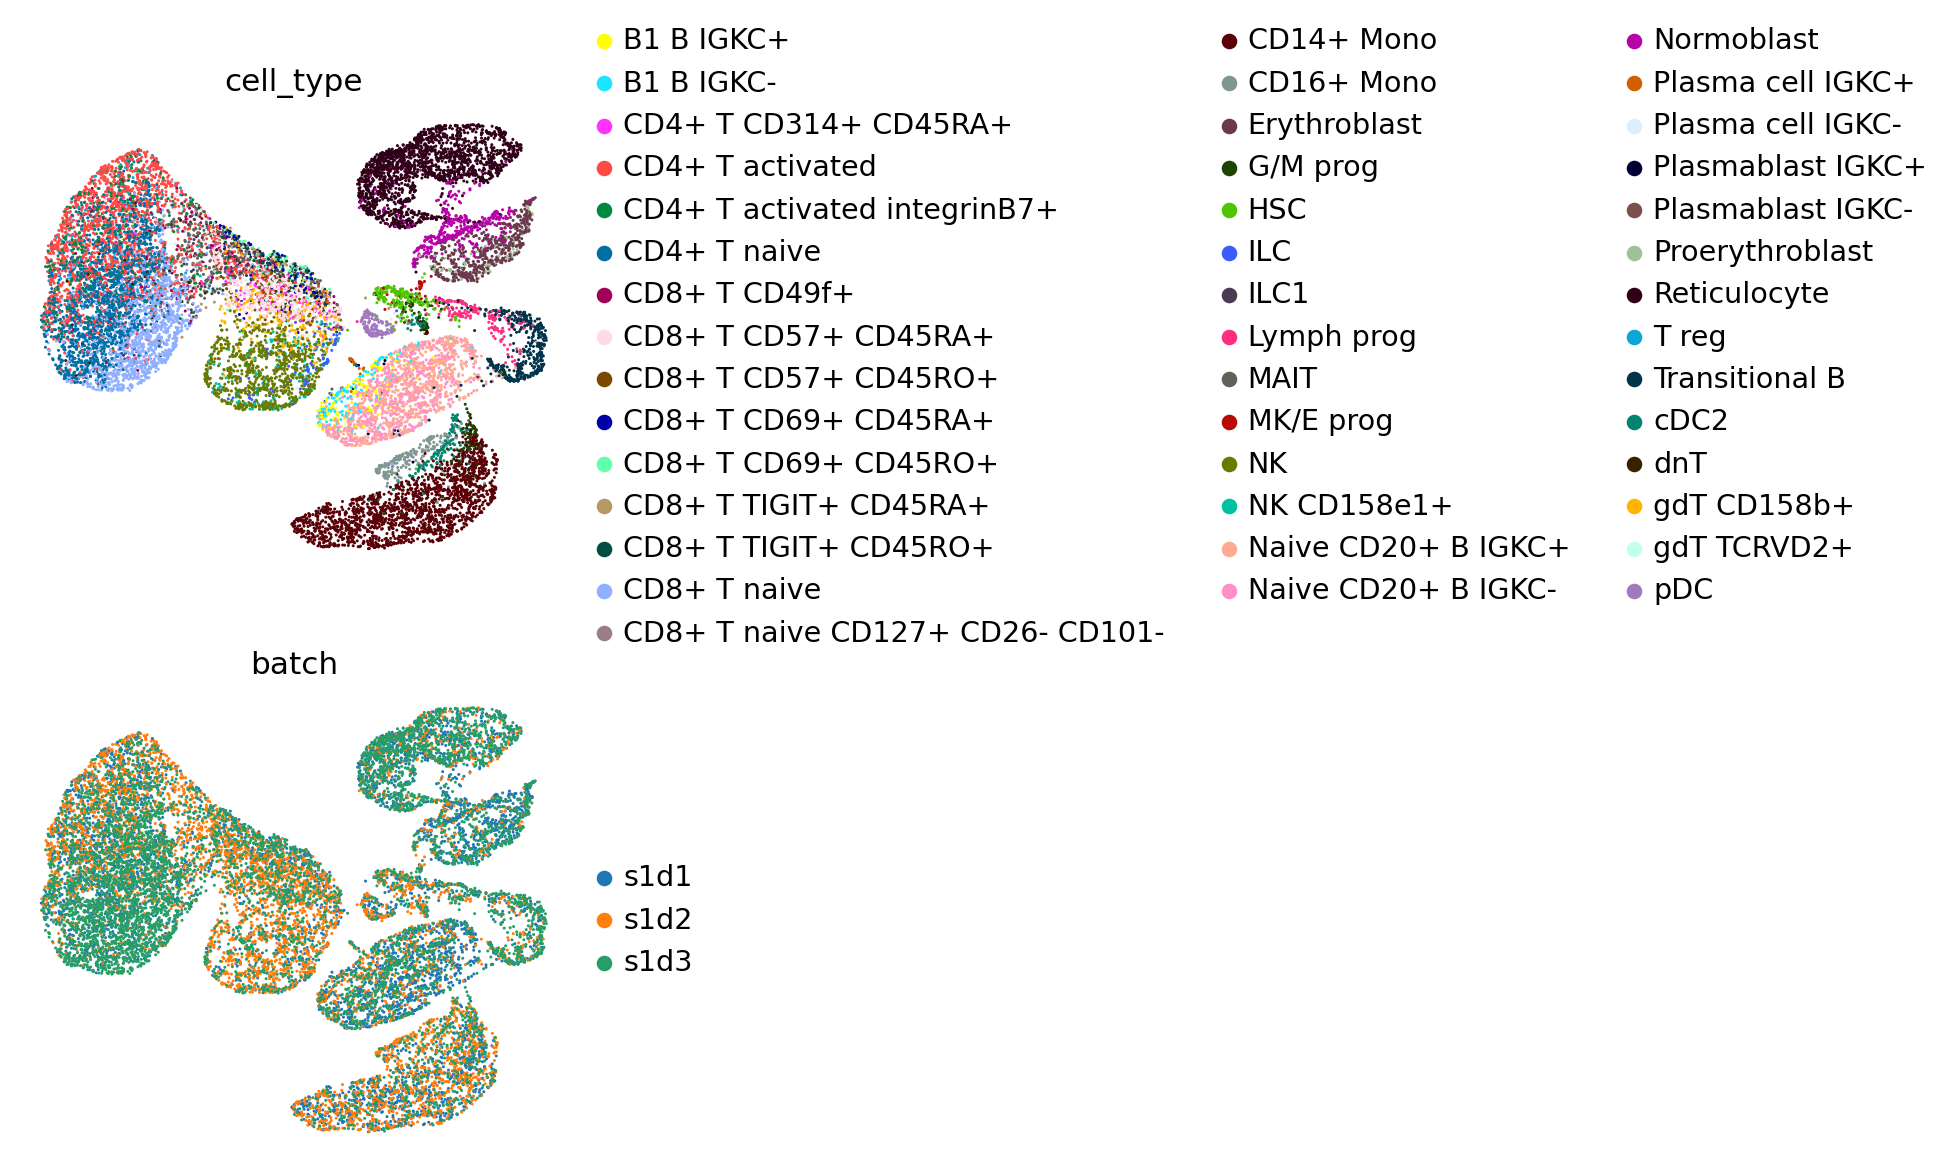

In [22]:
sc.pl.umap(adata_imputed_adt, color=['cell_type', 'batch'], ncols=1, frameon=False, save='_imputed_adt.svg')

In [15]:
adata_test_rna_pca = sc.AnnData(adata_test_rna.obsm['X_pca'])
adata_imputed_adt_pca = sc.AnnData(adata_imputed_adt.obsm['X_pca'])

In [18]:
sc.pp.scale(adata_test_rna_pca)
sc.pp.scale(adata_imputed_adt_pca)
adata_test_rna_imputed_adt_pca_scaled = ad.concat([adata_test_rna_pca, adata_imputed_adt_pca], axis=1)
adata_test_rna_imputed_adt_pca_scaled.obs = adata_test_rna.obs
adata_test_rna_imputed_adt_pca_scaled

/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/sc/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 16311 × 100
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'split', 'group', 'size_factors', '_scvi_batch'
    var: 'mean', 'std'

In [19]:
sc.pp.neighbors(adata_test_rna_imputed_adt_pca_scaled)
sc.tl.umap(adata_test_rna_imputed_adt_pca_scaled)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/sc/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


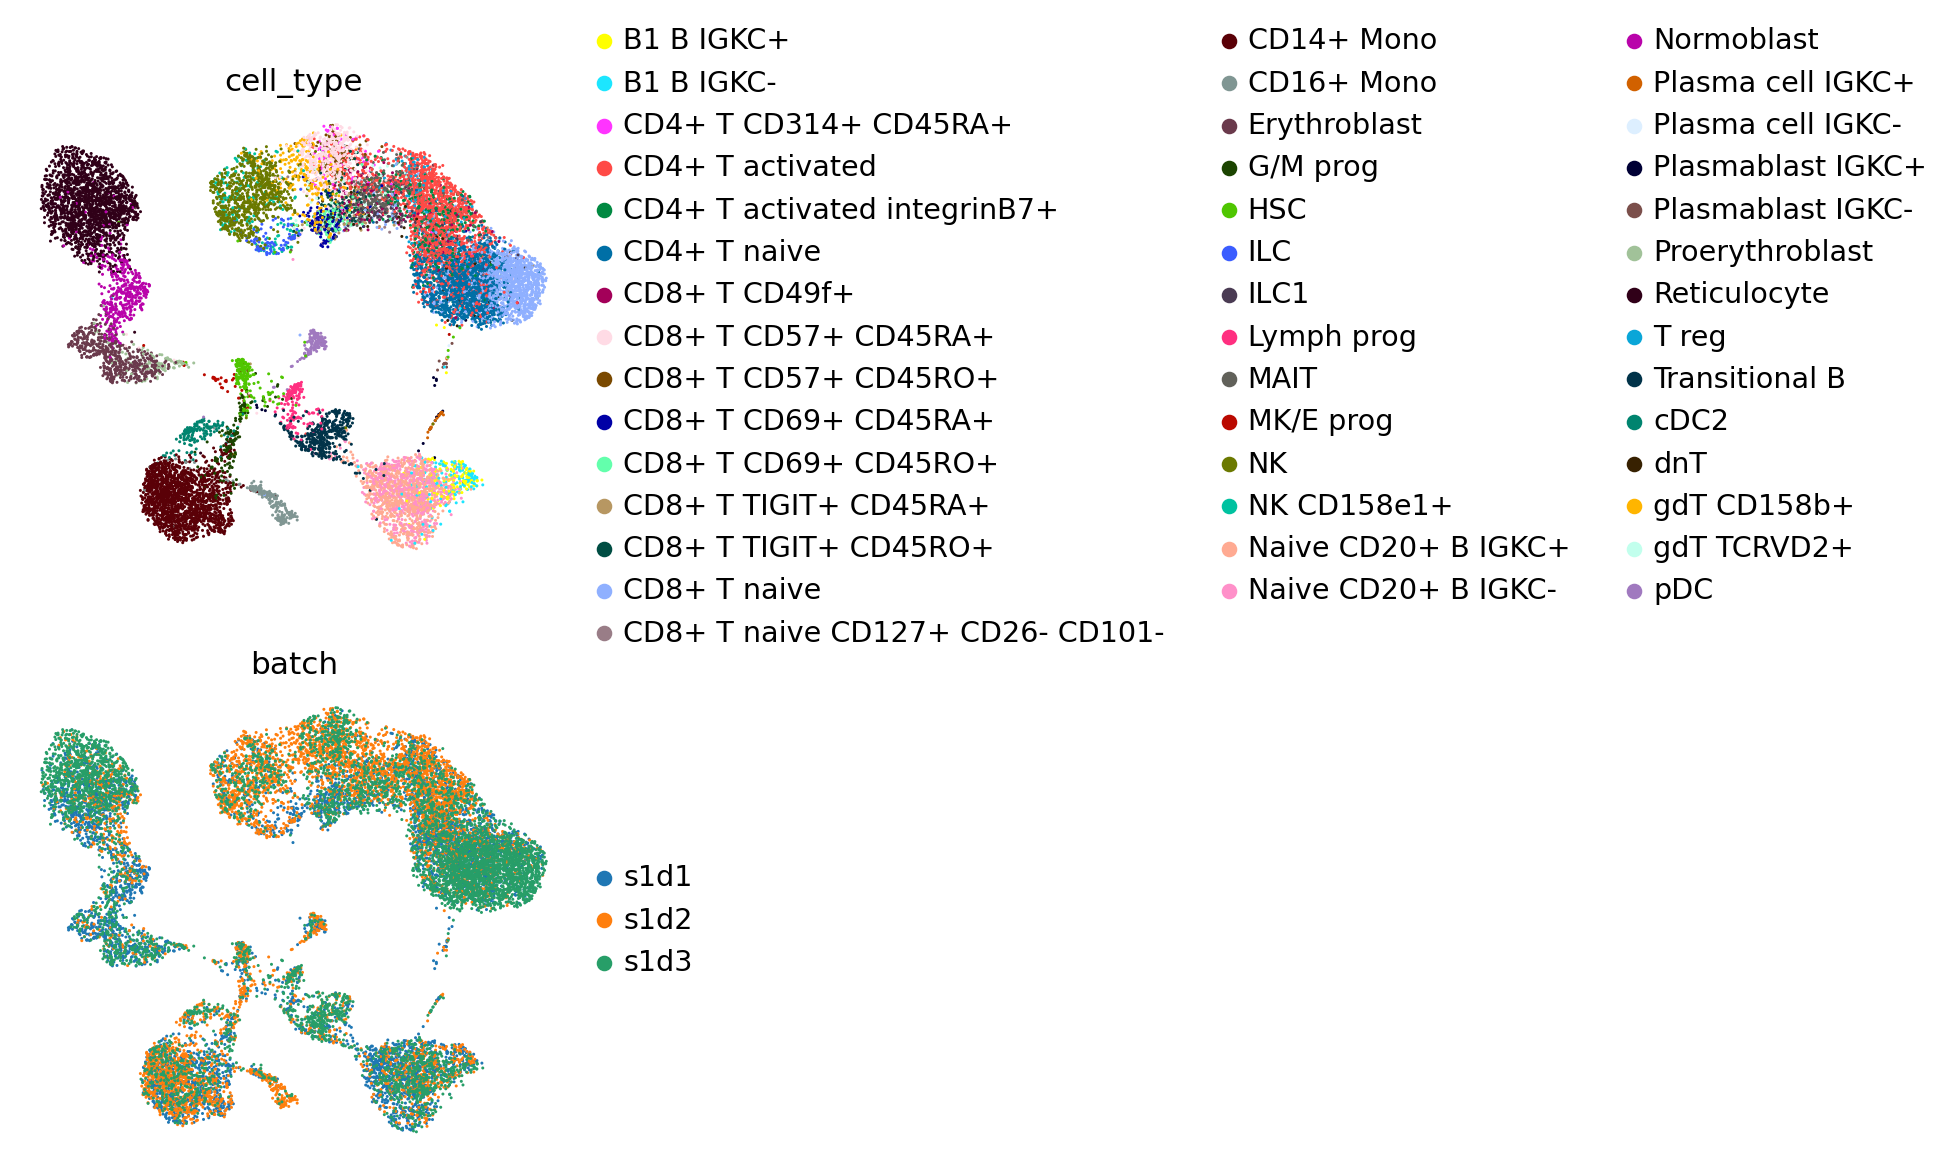

In [24]:
sc.pl.umap(adata_test_rna_imputed_adt_pca_scaled, color=['cell_type', 'batch'], ncols=1, frameon=False, save='_rna_imputed_adt.svg')

In [25]:
adata_test_rna.write('data/rna_test_fig.h5ad')
adata_test_rna_imputed_adt_pca_scaled.write('data/rna_imputed_adt_test_fig.h5ad')